In [1]:
_ = """
+ CutMix 
+ data_aug

"""

In [2]:
# traffic sign down
!gdown --id 1xFNMOCZbbYvGcFiYXQ2_mjc8Q799X13N
!unzip Train_AutoControl_org.zip
!gdown --id 1iPcAlduPW59v8mZSUqdrie2ZYnseG5Od
!unzip Test_AutoControl_org.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 extracting: Test_AutoControl/07052.png  
 extracting: Test_AutoControl/05079.png  
 extracting: Test_AutoControl/02073.png  
 extracting: Test_AutoControl/00613.png  
 extracting: Test_AutoControl/08337.png  
 extracting: Test_AutoControl/00698.png  
 extracting: Test_AutoControl/01529.png  
 extracting: Test_AutoControl/08133.png  
  inflating: Test_AutoControl/05321.png  
  inflating: Test_AutoControl/05989.png  
 extracting: Test_AutoControl/11670.png  
 extracting: Test_AutoControl/01235.png  
 extracting: Test_AutoControl/03188.png  
 extracting: Test_AutoControl/00152.png  
 extracting: Test_AutoControl/01453.png  
 extracting: Test_AutoControl/11682.png  
 extracting: Test_AutoControl/01751.png  
 extracting: Test_AutoControl/00612.png  
 extracting: Test_AutoControl/04497.png  
 extracting: Test_AutoControl/05205.png  
 extracting: Test_AutoControl/00008.png  
 extracting: Test_AutoControl/01625.png  
  inflating: Test_AutoControl/07560.png 

In [3]:
# # traffic sign down
# !gdown --id 1ysKr2SJAxGWrdSvoA5fn40jhRQmbPswl
# !gdown --id 1-MsSMJqE8AdMQYgS_tiYiaeTkiF4WB5F
# !unzip data.zip

In [4]:
!gdown --id 1-MsSMJqE8AdMQYgS_tiYiaeTkiF4WB5F

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-MsSMJqE8AdMQYgS_tiYiaeTkiF4WB5F
To: /content/Test_Label.csv
100% 118k/118k [00:00<00:00, 93.9MB/s]


In [5]:
!ls

sample_data	  Test_AutoControl_org.zip  Train_AutoControl
Test_AutoControl  Test_Label.csv	    Train_AutoControl_org.zip


In [6]:
pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 418 kB 13.9 MB/s 


In [7]:
# Few imports

import torch
import torchvision

from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch.utils.data as data
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn as nn
from torchsummary import summary
from __future__ import print_function
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.autograd import Variable

import zipfile
import time
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import argparse
import pandas as pd
import shutil
from PIL import Image

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from torchmetrics import F1Score

In [8]:
os.rename('./Test_AutoControl', './Test')
os.rename('./Train_AutoControl', './Train')

In [9]:
# # https://pytorch.org/docs/stable/notes/randomness.html

# # REPRODUCIBILITY
# # Controlling sources of randomness
def set_seed(RANDOM_SEED=333):
    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)
    os.environ['PYTHONHASHEED'] = str(RANDOM_SEED)
    
set_seed()

# torch.manual_seed(RANDOM_SEED)
# torch.cuda.manual_seed_all(RANDOM_SEED)

# random.seed(RANDOM_SEED)
# np.random.seed(RANDOM_SEED)

# def seed_worker(worker_id):
#     worker_seed = torch.initial_seed() % 2**32
#     np.random.seed(worker_seed)
#     random.seed(worker_seed)



# # reduced performance
# # torch.backends.cudnn.deterministic = True # torch.use_deterministic_algorithms(True)
# # torch.backends.cudnn.benchmark = False

In [10]:
# Before starting, clear the memory
torch.cuda.empty_cache()

In [11]:
# Define path of training data
train_data_path = "./Train"
data_transformer_stat = transforms.Compose([transforms.ToTensor()])
train_data_stat = torchvision.datasets.ImageFolder(root = train_data_path, transform = data_transformer_stat)
print(f"Number of training samples = {len(train_data_stat)}")

Number of training samples = 26010


In [12]:
# calculate the mean and standard deviation of train_data_stat

meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in train_data_stat]
stdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_ in train_data_stat]

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])

print(meanR, meanG, meanB)
print(stdR, stdG, stdB)

0.37563902 0.32400492 0.3496766
0.268135 0.2724744 0.28464803


In [13]:
# Define the transformations. To begin with, we shall keep it minimum - only resizing the images and converting them to PyTorch tensors

data_transforms = transforms.Compose([
    transforms.Resize([48, 48]),
    transforms.ToTensor(),
    transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB])
    ])

# # Define transformations

data_transforms_rand = transforms.Compose([
  transforms.RandomRotation(degrees=15),
  transforms.RandomAutocontrast(),
  transforms.RandomAdjustSharpness(4),
  transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.2, 0.5)),
  transforms.Resize([48, 48]),  
  # transforms.CenterCrop(112*0.8),
  # transforms.Resize([112, 112]),
  transforms.ToTensor(),
  transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB])
  ])

# data_transforms_rand_old = transforms.Compose([
#   transforms.RandomRotation(degrees=15),
#   transforms.RandomAutocontrast(),
#   transforms.RandomAdjustSharpness(4),
#   transforms.Resize([112, 112]),
#   transforms.GaussianBlur(kernel_size=(7, 7), sigma=(2, 4)),
#   # transforms.CenterCrop(112*0.8),
#   # transforms.Resize([112, 112]),
#   transforms.ToTensor(),
#   transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB])
#   ])



In [14]:
print(os.getcwd())
os.listdir()

/content


['.config',
 'Train_AutoControl_org.zip',
 'Test',
 'model_263_9874.pth',
 'Test_AutoControl_org.zip',
 'Test_Label.csv',
 'Train',
 'sample_data']

In [15]:
# Defining hyperparameters

BATCH_SIZE = 256
learning_rate = 0.001
EPOCHS = 15
numClasses = 43

In [ ]:
# Define path of training data

train_data_path = "./Train"
train_data_all = torchvision.datasets.ImageFolder(root = train_data_path, transform = data_transforms)
print(f"Number of training samples = {len(train_data_all)}")

Number of training samples = 26010


In [ ]:
import sympy

mul_num = 10
lst_aug = [train_data_all]
for i in range(mul_num) :
  set_seed(i)
  rand_priime = sympy.randprime(0, 10000)
  set_seed(rand_priime)
  train_data_aug = torchvision.datasets.ImageFolder(root = train_data_path, transform = data_transforms_rand)
  lst_aug.append(train_data_aug)
set_seed()

In [ ]:
train_data_aug = torch.utils.data.ConcatDataset(lst_aug)

In [ ]:
# Divide data into training and validation (0.8 and 0.2)
ratio = 0.8
n_train_examples = int(len(train_data_aug) * ratio)
n_val_examples = len(train_data_aug) - n_train_examples

train_data, val_data = data.random_split(train_data_aug, [n_train_examples, n_val_examples])

print(f"Number of training samples = {len(train_data)}")
print(f"Number of validation samples = {len(val_data)}")

Number of training samples = 228888
Number of validation samples = 57222


In [ ]:
## 너무 오래걸림 ㅠ
# # Plot histogram for training and validation data


# train_hist = [0]*numClasses
# for i, value in enumerate(train_data):
#     data, label = value
#     train_hist[int(label)] += 1
    
# val_hist = [0]*numClasses
# for i, value in enumerate(val_data):
#     data, label = value
#     train_hist[int(label)] += 1

# plt.bar(range(numClasses), train_hist, label="train")
# # plt.bar(range(numClasses), val_hist, label="val")
# legend = plt.legend(loc='upper right', shadow=True)
# plt.title("Distribution Plot")
# plt.xlabel("Class ID")
# plt.ylabel("# of examples")

# plt.savefig("train_val_split.png", bbox_inches = 'tight', pad_inches=0.5)

In [ ]:

# Create data loader for training and validation

# DataLoader(
#     train_dataset,
#     batch_size=batch_size,
#     num_workers=num_workers,
#     worker_init_fn=seed_worker
# )
train_aug_loader = DataLoader(train_data_aug, shuffle=True, batch_size = BATCH_SIZE)
train_loader = DataLoader(train_data, shuffle=True, batch_size = BATCH_SIZE)
val_loader = DataLoader(val_data, shuffle=True, batch_size = BATCH_SIZE)

# print(train_data_all[0][0].shape)
# print(train_data_all[0][1])
# print(len(train_data_all.samples))
# print(len(train_data_all.targets))
# print(len(train_data_all.classes))

In [ ]:
# Test_Label
test_ans = pd.read_csv('Test_Label.csv')

# Create Folder
os.mkdir('./Test_ans/')
for i in range(43) : 
  path = './Test_ans/'+str(i)
  if os.path.isdir(path) : 
    # os.rmdir(path)
    print('existing' + path)
  else : 
    os.mkdir(path)

# file path move for answer data validation

for f in  test_ans.iterrows():
  filename = f[1]['Filename']
  src = './Test/'
  dir = './Test_ans/'+str(f[1]['ClassId']) + '/'
  shutil.copy(src + filename, dir + filename)

In [ ]:
  # Define path of answer data
answer_data_path = "./Test_ans"
answer_data = torchvision.datasets.ImageFolder(root = answer_data_path, transform = data_transforms)
print(f"Number of answer samples = {len(answer_data)}")
answer_loader = DataLoader(answer_data, shuffle=False, batch_size = BATCH_SIZE)
# answer_loader = DataLoader(answer_data, shuffle=False, batch_size = BATCH_SIZE)
# print(answer_data.classes)
# print(answer_data.class_to_idx)

Number of answer samples = 8670


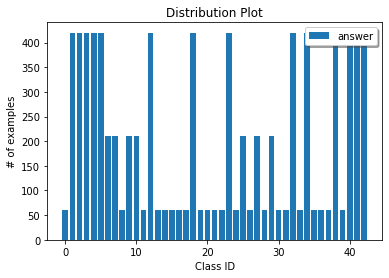

In [ ]:
# Plot histogram for ans data

ans_hist = [0]*numClasses
for i, value in enumerate(answer_data):
    data, label = value
    ans_hist[label] += 1

plt.bar(range(numClasses), ans_hist, label="answer")
legend = plt.legend(loc='upper right', shadow=True)
plt.title("Distribution Plot")
plt.xlabel("Class ID")
plt.ylabel("# of examples")

plt.savefig("answer.png", bbox_inches = 'tight', pad_inches=0.5)

In [ ]:
train_img = []  # imagefolder dataset 메모리에 올리기 위해 extract list
train_lab = []  
for (data, label) in train_data_aug :
  # print(label, data.shape)
  # print(data.numpy().shape)
  train_img.append(data.numpy())
  train_lab.append(label)
  # break
train_img = np.array(train_img)
train_lab = np.array(train_lab)
print(train_img.shape)
print(train_lab.shape)
train_img.reshape(len(train_lab), -1).shape

(286110, 3, 48, 48)
(286110,)


(286110, 6912)

In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN

smote = SMOTE(random_state = 0, k_neighbors = 5)
image_smote, label_smote = smote.fit_resample(train_img.reshape(len(train_lab), -1), train_lab)
s = train_img.shape
image_smote = image_smote.reshape(-1, s[1], s[2], s[3])
print(image_smote.shape)
print(label_smote.shape)

(595980, 3, 48, 48)
(595980,)


In [ ]:
# from torch.utils.data import TensorDataset, DataLoader

image_tensor = torch.tensor(image_smote, dtype=torch.float32)#.to("cuda:0")
label_tensor = torch.tensor(label_smote, dtype=torch.int64)#.to("cuda:0")
# from torch.utils.data import TensorDataset, DataLoader
train_ds = TensorDataset(image_tensor, label_tensor)
print(type(train_ds))
train_ds_loader = DataLoader(train_ds, shuffle=True, batch_size = BATCH_SIZE)

<class 'torch.utils.data.dataset.TensorDataset'>


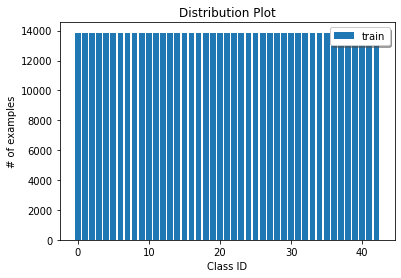

In [ ]:
# Plot histogram for training and validation data

train_hist = [0]*numClasses
for i, value in enumerate(train_ds):
    data, label = value
    # print(i, int(label), data.shape)
    # break
    train_hist[int(label)] += 1

plt.bar(range(numClasses), train_hist, label="train")
legend = plt.legend(loc='upper right', shadow=True)
plt.title("Distribution Plot")
plt.xlabel("Class ID")
plt.ylabel("# of examples")

plt.savefig("train_smote_split.png", bbox_inches = 'tight', pad_inches=0.5)

In [ ]:
# for i, value in enumerate(train_ds):
#     data, label = value
#     print(label, data.shape)
#     break

#F1 Score

In [ ]:
# class CustomImageDataset(Dataset):
#     def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
#         self.img_labels = pd.read_csv(annotations_file
#                                     #   , names=['Filename', 'ClassId']
#                                       )
#         self.img_dir = img_dir
#         self.transform = transform
#         self.target_transform = target_transform

#     def __len__(self):
#         return len(self.img_labels)

#     def __getitem__(self, idx):
#         img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
#         image = Image.open(img_path)
#         label = self.img_labels.iloc[idx, 1]
#         if self.transform:
#             image = self.transform(image)
#         if self.target_transform:
#             label = self.target_transform(label)
#         return image, label

# num = range(nclasses) # 43
# torch_class_to_real_class = [str(i) for i in num]
# torch_class_to_real_class = sorted(torch_class_to_real_class)
# torch_class_to_real_class = [int(torch_class_to_real_class[i]) for i in num]

# def evaluate_test(model, loader, torch_class_to_real_class):
#     model.eval()
#     y_true_list = []
#     y_pred_list_before_mapping = []
#     with torch.no_grad():
#         for (images, labels) in test_dataloader:
#             y_true_list.append(labels)
#             images = images.cuda()

#             output = model(images)
            
#             y_pred_tags = output.data.max(1, keepdim=True)[1]
#             y_pred_tags = y_pred_tags.cpu().numpy().reshape(-1)
#             y_pred_list_before_mapping.append(y_pred_tags)

    
#     y_true_list = np.concatenate(y_true_list)
#     total_y_pred_list_before_mapping = np.concatenate(y_pred_list_before_mapping)
#     y_pred_list = [torch_class_to_real_class[torch_class] for torch_class in total_y_pred_list_before_mapping]

#     macro_f1 = f1_score(
#         y_true = y_true_list,
#         y_pred = y_pred_list,
#         average = 'macro')
    
#     return macro_f1, y_pred_list

In [ ]:
# ans_file_name = "Test_Label.csv"
# img_dir = "Test"
# test_transform = transforms.Compose([
#     transforms.Resize([48, 48]),
#     transforms.ToTensor(),
#     transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629)) # need to change mean / std 
# ])
# test_batch_size = 1_000

# test_data = CustomImageDataset(ans_file_name, img_dir, test_transform)
# test_dataloader = torch.utils.data.DataLoader(test_data, shuffle=False, batch_size = test_batch_size)

In [ ]:
# # curr_score == F1 score  |  curr_y_pred_list : perd_resutl
# curr_score, curr_y_pred_list = evaluate_test(model, test_dataloader, torch_class_to_real_class

# MicronNet

In [16]:
nclasses = 43 # GTSRB as 43 classes

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 1, kernel_size=1)
        self.conv2 = nn.Conv2d(1, 29, kernel_size=5)
        self.maxpool2 = nn.MaxPool2d(3, stride=2 , ceil_mode=True)
        self.conv3 = nn.Conv2d(29, 59, kernel_size=3)
        self.maxpool3 = nn.MaxPool2d(3, stride=2 , ceil_mode=True)
        self.conv4 = nn.Conv2d(59, 74, kernel_size=3)
        self.maxpool4 = nn.MaxPool2d(3, stride=2 , ceil_mode=True)
        self.conv2_drop = nn.Dropout2d()
        self.conv3_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(1184, 300)
        self.fc2 = nn.Linear(300, nclasses)
        self.conv0_bn = nn.BatchNorm2d(3)
        self.conv1_bn = nn.BatchNorm2d(1)
        self.conv2_bn = nn.BatchNorm2d(29)
        self.conv3_bn = nn.BatchNorm2d(59)
        self.conv4_bn = nn.BatchNorm2d(74)
        self.dense1_bn = nn.BatchNorm1d(300)
    def forward(self, x):
        x =  F.relu(self.conv1_bn(self.conv1(self.conv0_bn(x))))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3( self.maxpool2(x))))
        x = F.relu(self.conv4_bn(self.conv4( self.maxpool3(x))))
        x = self.maxpool4(x)        
        x = x.view(-1, 1184)
        x = F.relu(self.fc1(x))
        x = self.dense1_bn(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.dropout(x, training=self.training)
        return F.log_softmax(x, -1)

In [17]:
epochs = 1000
# epochs = 10000
batch_size = 50
seed = 1
log_interval=512
data = "data"
torch.manual_seed(1)
lr =0.007
momentum = 0.9
# step = 1000
step = 50
decay =  0.9996
l2_norm = 0.00001
cuda = True
resume = False
# These may change as described in paper

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net()
if  cuda: 
    model.to(device)

if resume :
    state_dict = torch.load("model_28.pth")
    model.load_state_dict(state_dict) 

In [ ]:
# print(len(answer_loader.dataset))
# print(len(answer_loader))
# for i, (data, target) in enumerate(answer_loader):
#   print(i)

In [19]:
# https://stackoverflow.com/questions/65318064/can-i-trainoptimize-on-f1-score-loss-with-pytorch
# https://stackoverflow.com/questions/53354176/how-to-use-f-score-as-error-function-to-train-neural-networks
# loss <-- F-Measure as the Error Function to Train Neural Networks 
#

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    f1_score = 0
    f1 = F1Score(num_classes=nclasses).to(device) # .to(device)
    with torch.no_grad():
        start_time = time.monotonic()
        for data, target in answer_loader:
            # data, target = Variable(data), Variable(target)
            data = data.to(device)
            target =target.to(device)
            output = model(data)
            validation_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
            f1_score += f1(pred, target)
        validation_loss /= len(answer_loader.dataset)
        f1_score /= len(answer_loader)
        end_time = time.monotonic()
        print(f"\nValidation set: Average loss: {format(validation_loss, '.4f')}, f1 score : {format(f1_score, '.4f')}, Accuracy: {correct}/{len(answer_loader.dataset)} ({format(100. * correct / len(answer_loader.dataset), '.3f')}%)", end=' ')
        print(", Time = %.2f seconds" % (end_time - start_time))
    return validation_loss, f1_score


def train(epoch , train_loader):
    model.train()
    start_time = time.monotonic()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target).cuda()
        loss.backward()
        optimizer.step()
        # if batch_idx % log_interval == 0: len(train_loader)
        if batch_idx == len(train_loader)-1 :
            # print(f"Train Epoch: {epoch}\t[{batch_idx * len(data)}/{len(train_loader.dataset)}\t({format(100. * batch_idx / len(train_loader),'.3f')}%)]\tLoss: {format(loss.item(),'.6f')}")
            print(f"Train Epoch: {epoch}\tLoss: {format(loss.item(),'.6f')}", end=' ')
    end_time = time.monotonic()
    print("Time = %.2f seconds" % (end_time - start_time), end=' ')


In [ ]:
# # https://stackoverflow.com/questions/65318064/can-i-trainoptimize-on-f1-score-loss-with-pytorch
# # https://stackoverflow.com/questions/53354176/how-to-use-f-score-as-error-function-to-train-neural-networks
# # loss <-- F-Measure as the Error Function to Train Neural Networks 
# #

# def validation():
#     model.eval()
#     validation_loss = 0
#     correct = 0
#     with torch.no_grad():
#         for data, target in answer_loader:
#             # data, target = Variable(data), Variable(target)
#             data = data.to(device)
#             target =target.to(device)
#             output = model(data)
#             validation_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
#             pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
#             correct += pred.eq(target.data.view_as(pred)).cpu().sum()
#         validation_loss /= len(val_loader.dataset)
#         print(f"\nValidation set: Average loss: {format(validation_loss, '.4f')}, Accuracy: {correct}/{len(answer_loader.dataset)} ({format(100. * correct / len(answer_loader.dataset), '.0f')}%)\n")
#     return validation_loss


# def train(epoch , train_loader):
#     model.train()
#     for batch_idx, (data, target) in enumerate(train_loader):
#         data, target = Variable(data), Variable(target)
#         data = data.to(device)
#         target = target.to(device)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = F.nll_loss(output, target).cuda()
#         loss.backward()
#         optimizer.step()
#         if batch_idx % log_interval == 0:
#             print(f"Train Epoch: {epoch}\t[{batch_idx * len(data)}/{len(train_loader.dataset)}\t({format(100. * batch_idx / len(train_loader),'.3f')}%)]\tLoss: {format(loss.item(),'.6f')}")


In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr , momentum=momentum, weight_decay=l2_norm, nesterov=True)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay)
# train_ds_loader train_aug_loader
# temp = 10
temp_f1 = 0.9
epochs = 10000
best_model_epoch = 0
for epoch in range(1, epochs):
    train(epoch, train_ds_loader)
    val, f1 = validation()
    if epoch % step == 0 :
        scheduler.step()
    if f1 > temp_f1 : 
        temp_f1 = f1
        best_model_epoch = epoch
        model_file = 'model_' + str(epoch) + '.pth'
        torch.save(model.state_dict(), model_file)
        print('\nSaved model to ' + model_file + '. You can run `python evaluate.py ' + model_file + '` to generate the Kaggle formatted csv file')
    # if val < temp : 
    #     temp = val
    #     model_file = 'model_' + str(epoch) + '.pth'
    #     torch.save(model.state_dict(), model_file)
    #     print('\nSaved model to ' + model_file + '. You can run `python evaluate.py ' + model_file + '` to generate the Kaggle formatted csv file')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Train Epoch: 1	Loss: 2.155100 Time = 31.06 seconds 
Validation set: Average loss: 0.2260, f1 score : 0.9643, Accuracy: 8360/8670 (96.424%) , Time = 5.62 seconds

Saved model to model_1.pth. You can run `python evaluate.py model_1.pth` to generate the Kaggle formatted csv file
Train Epoch: 2	Loss: 2.067188 Time = 30.04 seconds 
Validation set: Average loss: 0.1397, f1 score : 0.9727, Accuracy: 8432/8670 (97.255%) , Time = 4.84 seconds

Saved model to model_2.pth. You can run `python evaluate.py model_2.pth` to generate the Kaggle formatted csv file
Train Epoch: 3	Loss: 1.051686 Time = 30.06 seconds 
Validation set: Average loss: 0.1178, f1 score : 0.9759, Accuracy: 8460/8670 (97.578%) , Time = 4.87 seconds

Saved model to model_3.pth. You can run `python evaluate.py model_3.pth` to generate the Kaggle formatted csv file
Train Epoch: 4	Loss: 1.356396 Time = 30.02 seconds 
Validation set: Average loss: 0.1181, f1 score : 0.9708, Accuracy: 8416/8670 (97.070%) , Time = 4.89 seconds
Train Ep

KeyboardInterrupt: ignored

In [ ]:
from google.colab import files
files.download(model_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Print confusion matrix

def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (20, 20));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)
    
labels_arr = range(0, nclasses)
# plot_confusion_matrix(labels_list, y_pred_list, labels_arr)

In [20]:
# Load the saved model
model_file = 'model_263_9874.pth'
model = Net()
model.load_state_dict(torch.load(model_file)) # 'model_35.pth'
model = model.cuda()

# model = Net()
# model.load_state_dict(torch.load('model_35.pth')) # 'model_35.pth'
# model = model.cuda()

In [21]:
test_answer = pd.read_csv('Test_Label.csv')
test_answer["pred_class"] = -1

num = range(nclasses)
labels = []
for i in num:
    labels.append(str(i))
labels = sorted(labels)
for i in num:
    labels[i] = int(labels[i])


test_transforms = transforms.Compose([
    transforms.Resize([48, 48]),
    transforms.ToTensor(),
    transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB])
])


# Perform classification

y_pred_list = []
corr_classified = 0
numExamples = len(test_answer)

##
labels_list = []



with torch.no_grad():
    model.eval()
    for f_name in test_answer["Filename"]:
        image = Image.open(f"Test//{f_name}")

        image = test_transforms(image)
        image = torch.unsqueeze(image, 0)
        # image = Variable(image)
        image = image.to(device)

        y_test_pred = model(image)
        y_pred_tags = y_test_pred.data.max(1, keepdim=True)[1]
        y_pred_tags = y_pred_tags.cpu().numpy()
        # print(y_pred_tags)

        y_pred = y_pred_tags[0][0]
        y_pred = labels[y_pred]
        
        y_pred_list.append(y_pred)

        test_answer.loc[test_answer[test_answer["Filename"] == f_name].index, "pred_class"] = y_pred
        if test_answer[test_answer["Filename"] == f_name]["ClassId"].values[0] == y_pred:
            corr_classified += 1

        # i += 1

print("Number of correctly classified images = %d" % corr_classified)
print("Number of incorrectly classified images = %d" % (numExamples - corr_classified))
print("Final accuracy = %f" % (corr_classified / numExamples))

# Print classification report
print(classification_report(test_answer.ClassId, y_pred_list))

# plot_confusion_matrix(test_answer.ClassId, y_pred_list, labels_arr)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Number of correctly classified images = 8570
Number of incorrectly classified images = 100
Final accuracy = 0.988466
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        60
           1       0.98      1.00      0.99       420
           2       0.99      1.00      0.99       420
           3       1.00      0.98      0.99       420
           4       1.00      0.99      0.99       420
           5       0.97      0.99      0.98       420
           6       1.00      0.83      0.91        60
           7       1.00      1.00      1.00       420
           8       0.99      0.99      0.99       420
           9       0.98      1.00      0.99       420
          10       1.00      1.00      1.00       420
          11       0.98      1.00      0.99       420
          12       0.99      1.00      0.99       420
          13       1.00      1.00      1.00       420
          14       1.00      1.00      1.00       210
          15      

NameError: ignored

In [28]:
test_answer

,Filename,ClassId,pred_class
0,00000.png,16,16
1,00001.png,1,1
2,00002.png,38,38
3,00003.png,33,33
4,00004.png,11,11
...,...,...,...
8665,12577.png,11,11
8666,12584.png,11,11
8667,12611.png,11,11
8668,12614.png,0,0


In [29]:
test_answer[['Filename', 'pred_class']].to_csv('team8_3.csv',index=False, header = None)

# AlexnetTS

In [ ]:
# # Function to count the number of parameters in the model

# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:

# import torch.nn as nn

# class AlexnetTS(nn.Module):
#     def __init__(self, output_dim):
#         super().__init__()
        
#         self.features = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
#             nn.MaxPool2d(kernel_size=2),
#             nn.ReLU(inplace=True),
            
#             nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1),
#             nn.MaxPool2d(kernel_size=2),
#             nn.ReLU(inplace=True),
            
#             nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
            
#             nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
            
#             nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
#             nn.MaxPool2d(kernel_size=2),
#             nn.ReLU(inplace=True),
#             )
        
#         self.classifier = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.Linear(256*7*7, 1000),
#             nn.ReLU(inplace=True),
            
#             nn.Dropout(0.5),
#             nn.Linear(in_features=1000, out_features=256),
#             nn.ReLU(inplace=True),
            
#             nn.Linear(256, output_dim)
#             )
        
#     def forward(self, x):
#         x = self.features(x)
#         h = x.view(x.shape[0], -1)
#         x = self.classifier(h)
#         return x, h

In [ ]:
# # Initialize the model
# # The model is defined in the class AlexnetTS in the file class_alexnetTS.py

# model = AlexnetTS(numClasses)
# print(f'The model has {count_parameters(model):,} trainable parameters')

# # Define optimizer and criterion functions

# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# criterion = nn.CrossEntropyLoss()

# # If CUDA is available, convert model and loss to cuda variables

# if torch.cuda.is_available():
#     model = model.cuda()
#     criterion = criterion.cuda()

# # Print model
# print(model)

# # Print summary of the model for the given dimension of the image
# print(summary(model, (3, 48, 48))) 

# # Print model's state dict
# print("Model's state dict:")
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())
# print("")

# # Print optimizer details

# print("Optimizer details:")
# print(optimizer)
# print("")

In [ ]:
# # Function to calculate accuracy

# def calculate_accuracy(y_pred, y):
#     top_pred = y_pred.argmax(1, keepdim = True)
#     correct = top_pred.eq(y.view_as(top_pred)).sum()
#     acc = correct.float() / y.shape[0]
#     return acc

In [ ]:
# # Function to perform training of the model

# def train(model, loader, opt, criterion):
#     epoch_loss = 0
#     epoch_acc = 0
    
#     # Train the model
#     model.train()
    
#     for (images, labels) in loader:
#         images = images.cuda()
#         labels = labels.cuda()
#         # labels = labels.cuda().type(torch.LongTensor)
        
#         # Training pass
#         opt.zero_grad()
        
#         output, _ = model(images)
#         loss = criterion(output, labels)
        
#         # Backpropagation
#         loss.backward()
        
#         # Calculate accuracy
#         acc = calculate_accuracy(output, labels)
        
#         # Optimizing weights
#         opt.step()
        
#         epoch_loss += loss.item()
#         epoch_acc += acc.item()
        
#     return epoch_loss / len(loader), epoch_acc / len(loader)

In [ ]:
# # Function to perform evaluation on the trained model

# def evaluate(model, loader, opt, criterion):
#     epoch_loss = 0
#     epoch_acc = 0
    
#     # Evaluate the model
#     model.eval()
    
#     with torch.no_grad():
#         for (images, labels) in loader:
#             images = images.cuda()
#             labels = labels.cuda()
            
#             # Run predictions
#             output, _ = model(images)
#             loss = criterion(output, labels)
            
#             # Calculate accuracy
#             acc = calculate_accuracy(output, labels)
            
#             epoch_loss += loss.item()
#             epoch_acc += acc.item()
    
#     return epoch_loss / len(loader), epoch_acc / len(loader)

In [ ]:
# # Perform training
# local_epoch = 50
# # List to save training and val loss and accuracies
# # train_loss_list = [0]*EPOCHS
# # train_acc_list = [0]*EPOCHS
# # val_loss_list = [0]*EPOCHS
# # val_acc_list = [0]*EPOCHS
# train_loss_list = [0]*local_epoch
# train_acc_list = [0]*local_epoch
# val_loss_list = [0]*local_epoch
# val_acc_list = [0]*local_epoch

# # for epoch in range(EPOCHS):
# for epoch in range(local_epoch):
#     print("Epoch-%d: " % (epoch))

#     train_start_time = time.monotonic()
#     # train_loss, train_acc = train(model, answer_loader, optimizer, criterion)
#     # train_loss, train_acc = train(model, train_all_loader, optimizer, criterion)
#     train_loss, train_acc = train(model, train_aug_loader, optimizer, criterion)
#     train_end_time = time.monotonic()

#     val_start_time = time.monotonic()
#     # val_loss, val_acc = evaluate(model, val_loader, optimizer, criterion) # val data
#     val_loss, val_acc = evaluate(model, answer_loader, optimizer, criterion) # answer data
#     val_end_time = time.monotonic()
    
#     train_loss_list[epoch] = train_loss
#     train_acc_list[epoch] = train_acc
#     val_loss_list[epoch] = val_loss
#     val_acc_list[epoch] = val_acc
    
#     print("Training: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds" % (train_loss, train_acc, train_end_time - train_start_time))
#     print("Validation: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds" % (val_loss, val_acc, val_end_time - val_start_time))
#     print("")

In [ ]:
# # Saving the model

# # Create folder to save model
# MODEL_FOLDER = "./Model"
# if not os.path.isdir(MODEL_FOLDER):
#     os.mkdir(MODEL_FOLDER)
    
# PATH_TO_MODEL = MODEL_FOLDER + "/pytorch_classification_alexnetTS.pth"
# if os.path.exists(PATH_TO_MODEL):
#     os.remove(PATH_TO_MODEL)
# torch.save(model.state_dict(), PATH_TO_MODEL)

# print("Model saved at %s" %(PATH_TO_MODEL))

In [ ]:
# # Plot loss and accuracies for training and validation data

# _, axs = plt.subplots(1, 2, figsize=(15, 5))

# # Loss plot
# axs[0].plot(train_loss_list, label="train")
# axs[0].plot(val_loss_list, label="val")
# axs[0].set_title("Plot - Loss")
# axs[0].set_xlabel("Epochs")
# axs[0].set_ylabel("Loss")
# legend = axs[0].legend(loc='upper right', shadow=False)

# # Accuracy plot
# axs[1].plot(train_acc_list, label="train")
# axs[1].plot(val_acc_list, label="val")
# axs[1].set_title("Plot - Accuracy")
# axs[1].set_xlabel("Epochs")
# axs[1].set_ylabel("Accuracy")
# legend = axs[1].legend(loc='center right', shadow=True)

In [ ]:
# test_answer = pd.read_csv('Test_Label.csv')
# test_answer["pred_class"] = -1

# num = range(numClasses)
# labels = []
# for i in num:
#     labels.append(str(i))
# labels = sorted(labels)
# for i in num:
#     labels[i] = int(labels[i])

# # Perform classification
# # test_transforms = transforms.Compose([
# #     transforms.Resize([112, 112]),
# #     transforms.ToTensor()
# #     ])
# test_transforms = transforms.Compose([
#     transforms.Resize([48, 48]),
#     transforms.ToTensor(),
#     # transforms.Normalize(mean=1, std=0.5)
#     ])
        
# y_pred_list = []
# corr_classified = 0
# numExamples = len(test_answer)

# ##
# labels_list = []

# with torch.no_grad():
#     model.eval()
#     for f_name in test_answer["Filename"]:
#         image = Image.open(f"Test//{f_name}")

#         image = test_transforms(image)
#         image = torch.unsqueeze(image, 0)
#         image = image.cuda()

#         y_test_pred = model(image)

#         y_pred_softmax = torch.log_softmax(y_test_pred[0], dim=1)
#         _, y_pred_tags = torch.max(y_pred_softmax, dim=1)
#         y_pred_tags = y_pred_tags.cpu().numpy()

#         y_pred = y_pred_tags[0]
#         y_pred = labels[y_pred]
        
#         y_pred_list.append(y_pred)

#         test_answer.loc[test_answer[test_answer["Filename"] == f_name].index, "pred_class"] = y_pred
#         if test_answer[test_answer["Filename"] == f_name]["ClassId"].values[0] == y_pred:
#             corr_classified += 1

#         # i += 1

# print("Number of correctly classified images = %d" % corr_classified)
# print("Number of incorrectly classified images = %d" % (numExamples - corr_classified))
# print("Final accuracy = %f" % (corr_classified / numExamples))

# # Print classification report
# print(classification_report(test_answer.ClassId, test_answer.pred_class))

# # plot_confusion_matrix(test_answer.ClassId, test_answer.pred_class, labels_arr)

In [ ]:
# Number of correctly classified images = 8452
# Number of incorrectly classified images = 218
# Final accuracy = 0.974856
#               precision    recall  f1-score   support

#            0       1.00      1.00      1.00        60
#            1       0.99      0.99      0.99       420
#            2       0.97      0.97      0.97       420
#            3       0.96      0.99      0.97       420
#            4       1.00      0.98      0.99       420
#            5       0.98      0.97      0.97       420
#            6       1.00      0.87      0.93        60
#            7       0.99      1.00      1.00       420
#            8       1.00      0.99      0.99       420
#            9       1.00      1.00      1.00       420
#           10       1.00      0.99      1.00       420
#           11       0.94      0.99      0.97       420
#           12       0.99      0.98      0.99       420
#           13       0.99      0.99      0.99       420
#           14       1.00      1.00      1.00       210
#           15       0.99      0.99      0.99       210
#           16       1.00      1.00      1.00        60
#           17       1.00      1.00      1.00       210
#           18       0.98      0.87      0.92       210
#           19       0.98      1.00      0.99        60
#           20       0.92      0.98      0.95        60
#           21       0.98      0.75      0.85        60
#           22       1.00      0.98      0.99        60
#           23       1.00      0.80      0.89        60
#           24       0.97      0.95      0.96        60
#           25       0.99      0.98      0.98       420
#           26       1.00      0.92      0.96        60
#           27       0.79      0.55      0.65        60
#           28       0.78      0.98      0.87        60
#           29       0.88      1.00      0.94        60
#           30       0.61      0.58      0.60        60
#           31       0.90      0.99      0.94       210
#           32       0.83      1.00      0.91        60
#           33       0.99      0.99      0.99       210
#           34       1.00      1.00      1.00        60
#           35       1.00      1.00      1.00       210
#           36       0.98      1.00      0.99        60
#           37       1.00      1.00      1.00        60
#           38       1.00      0.99      0.99       420
#           39       0.94      0.98      0.96        60
#           40       1.00      0.97      0.98        60
#           41       0.79      0.93      0.85        60
#           42       1.00      1.00      1.00        60

#     accuracy                           0.97      8670
#    macro avg       0.96      0.95      0.95      8670
# weighted avg       0.98      0.97      0.97      8670

In [ ]:
# test_answer = pd.read_csv('Test_Label.csv')
# test_answer["pred_class"] = -1

# num = range(numClasses)
# labels = []
# for i in num:
#     labels.append(str(i))
# labels = sorted(labels)
# for i in num:
#     labels[i] = int(labels[i])

# # Perform classification
# test_transforms = transforms.Compose([
#     transforms.Resize([48, 48]),
#     transforms.ToTensor(),
#     # transforms.Normalize(mean=1, std=0.5)
#     ])
        
# y_pred_list = []
# corr_classified = 0
# numExamples = len(test_answer)

# ##
# labels_list = []
# wronng_list = []
# with torch.no_grad():
#     model.eval()
#     for f_name in test_answer["Filename"]:
#         image = Image.open(f"Test//{f_name}")

#         image = test_transforms(image)
#         image = torch.unsqueeze(image, 0)
#         image = image.cuda()

#         y_test_pred = model(image)

#         y_pred_softmax = torch.log_softmax(y_test_pred[0], dim=1)
#         _, y_pred_tags = torch.max(y_pred_softmax, dim=1)
#         y_pred_tags = y_pred_tags.cpu().numpy()

#         y_pred = y_pred_tags[0]
#         y_pred = labels[y_pred]
        
#         y_pred_list.append(y_pred)

#         test_answer.loc[test_answer[test_answer["Filename"] == f_name].index, "pred_class"] = y_pred
#         if test_answer[test_answer["Filename"] == f_name]["ClassId"].values[0] == y_pred:
#             corr_classified += 1
#         else : 
#           wronng_list.append([f_name,test_answer[test_answer["Filename"] == f_name]["ClassId"].values[0], y_pred])
#         # i += 1

# print("Number of correctly classified images = %d" % corr_classified)
# print("Number of incorrectly classified images = %d" % (numExamples - corr_classified))
# print("Final accuracy = %f" % (corr_classified / numExamples))

# # Print classification report
# print(classification_report(test_answer.ClassId, test_answer.pred_class))

# # plot_confusion_matrix(test_answer.ClassId, test_answer.pred_class, labels_arr)

In [ ]:
# df = pd.DataFrame(wronng_list) ## 데이터프래임 생성
# df.to_csv('wronng_list.csv',index=False) ## 구분자를 탭으로 하여 저장. 인덱스칼럼은 저장 안함.

In [ ]:
# # Print confusion matrix

# def plot_confusion_matrix(labels, pred_labels, classes):
    
#     fig = plt.figure(figsize = (20, 20));
#     ax = fig.add_subplot(1, 1, 1);
#     # print(labels)
#     # print(pred_labels)
#     cm = confusion_matrix(labels, pred_labels);
#     cm = ConfusionMatrixDisplay(cm, display_labels = classes);
#     cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
#     plt.xticks(rotation = 20)
    
# labels_arr = range(0, numClasses)
# # plot_confusion_matrix(test_answer.ClassId, test_answer.pred_class, labels_arr)
# plot_confusion_matrix(test_answer.ClassId, y_pred_list, labels_arr)


# test using val_data

In [ ]:
# val_data.dataset

In [ ]:
# # Load the saved model

# model = AlexnetTS(numClasses)
# model.load_state_dict(torch.load(PATH_TO_MODEL))
# model = model.cuda()

In [ ]:
# # Perform classification

# y_pred_list = []
# corr_classified = 0
# # numExamples = len(val_data)
# numExamples = len(val_data)

# ##
# labels_list = []

# with torch.no_grad():
#     model.eval()

#     # i = 0

#     for image, label_true in data.DataLoader(val_data, shuffle=True, batch_size = 1): # shuffle = False when test
#         labels_list.append(label_true.cpu().numpy()[0])
#         image = image.cuda()

#         y_test_pred = model(image)

#         y_pred_softmax = torch.log_softmax(y_test_pred[0], dim=1)
#         _, y_pred_tags = torch.max(y_pred_softmax, dim=1)
#         y_pred_tags = y_pred_tags.cpu().numpy()

#         y_pred_list.append(y_pred_tags[0])
#         if label_true == y_pred_tags[0]:
#             corr_classified += 1

#         # i += 1

# print("Number of correctly classified images = %d" % corr_classified)
# print("Number of incorrectly classified images = %d" % (numExamples - corr_classified))
# print("Final accuracy = %f" % (corr_classified / numExamples))

In [ ]:
# # Print classification report

# print(classification_report(labels_list, y_pred_list))

In [ ]:
# # Print confusion matrix

# def plot_confusion_matrix(labels, pred_labels, classes):
    
#     fig = plt.figure(figsize = (20, 20));
#     ax = fig.add_subplot(1, 1, 1);
#     cm = confusion_matrix(labels, pred_labels);
#     cm = ConfusionMatrixDisplay(cm, display_labels = classes);
#     cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
#     plt.xticks(rotation = 20)
    
# labels_arr = range(0, numClasses)
# plot_confusion_matrix(labels_list, y_pred_list, labels_arr)
